<a href="https://colab.research.google.com/github/julio4development/pytorch1/blob/main/02_exercises_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
from sklearn.datasets import make_moons

In [48]:
X, y = make_moons(1000, noise=0.03, random_state=42)

In [49]:
import matplotlib.pyplot as plt

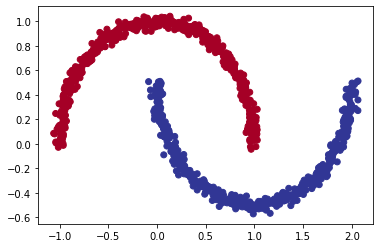

In [50]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [51]:
import pandas as pd
moons = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


In [52]:
import torch
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [56]:
device

'cuda'

In [57]:
from torch import nn
class MoonModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = MoonModelV2().to(device)
print(model_3)

MoonModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [58]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [59]:
def accuracy_fn(y_true, y_pred):
  # torch.eq calculate if 2 tensors are equal
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [60]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.68674, Accuracy: 50.00% | Test Loss: 0.68171, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.28038, Accuracy: 86.50% | Test Loss: 0.29231, Test Accuracy: 87.50%
Epoch: 200 | Loss: 0.23514, Accuracy: 88.88% | Test Loss: 0.23714, Test Accuracy: 89.50%
Epoch: 300 | Loss: 0.22229, Accuracy: 89.88% | Test Loss: 0.22463, Test Accuracy: 89.50%
Epoch: 400 | Loss: 0.21283, Accuracy: 90.00% | Test Loss: 0.21750, Test Accuracy: 90.00%
Epoch: 500 | Loss: 0.20663, Accuracy: 90.25% | Test Loss: 0.21353, Test Accuracy: 88.50%
Epoch: 600 | Loss: 0.20307, Accuracy: 90.62% | Test Loss: 0.21166, Test Accuracy: 87.50%
Epoch: 700 | Loss: 0.20121, Accuracy: 90.38% | Test Loss: 0.21090, Test Accuracy: 87.50%
Epoch: 800 | Loss: 0.20021, Accuracy: 89.75% | Test Loss: 0.21058, Test Accuracy: 87.50%
Epoch: 900 | Loss: 0.19957, Accuracy: 89.62% | Test Loss: 0.21043, Test Accuracy: 87.50%


In [61]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [62]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


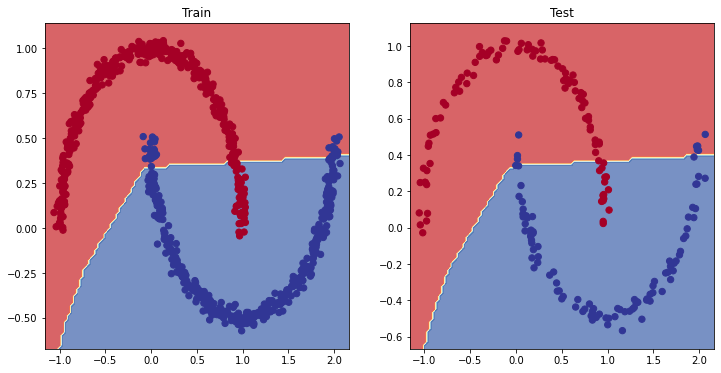

In [63]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

ValueError: ignored

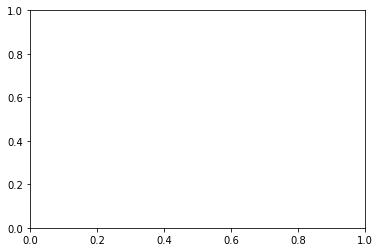

In [67]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
NUM_FEATURES = 2 # dimensionality
NUM_CLASSES = 3 # number of classes
X_spiral = np.zeros((N*K,D)) # data matrix (each row = single example)
y_spiral = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X_spiral[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y_spiral[ix] = j
# lets visualize the data
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [68]:
# 2. Turn data into tensors
X_spiral = torch.from_numpy(X_spiral).type(torch.float)
y_spiral = torch.from_numpy(y_spiral).type(torch.LongTensor)
print(X_spiral[:5], y_blob[:5])

tensor([[-0.0000e+00,  0.0000e+00],
        [-8.8819e-05,  1.0101e-02],
        [-4.4979e-04,  2.0197e-02],
        [ 5.0545e-04,  3.0299e-02],
        [ 1.8925e-02,  3.5698e-02]]) [0 0 0 0 0]


In [69]:
# 3. Split into train and test sets
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral,
    y_spiral,
    test_size=0.2,
    random_state=42
)

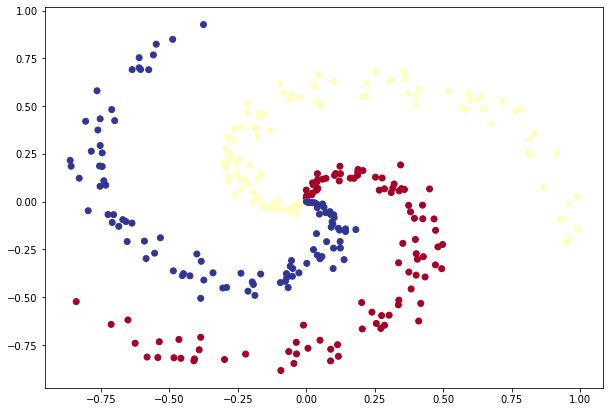

In [70]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, cmap=plt.cm.RdYlBu);

In [71]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [72]:
from torch import nn

# Build model
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = SpiralModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [73]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

In [74]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_spiral_train.to(device))[:5]

tensor([[-0.0585, -0.3534, -0.2101],
        [-0.0812, -0.3456, -0.2427],
        [-0.0720, -0.3838, -0.2498],
        [-0.2076, -0.3711, -0.4347],
        [-0.1344, -0.4210, -0.3537]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [75]:
# How many elements in a single prediction sample?
model_4(X_spiral_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([3]), 3)

In [76]:
# Make prediction logits with model
y_logits = model_4(X_spiral_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0736, -0.3835, -0.2462],
        [-0.0519, -0.3174, -0.1943],
        [-0.0883, -0.4183, -0.2966],
        [-0.0746, -0.3885, -0.2543],
        [-0.0720, -0.3515, -0.2304]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3884, 0.2849, 0.3268],
        [0.3796, 0.2911, 0.3293],
        [0.3951, 0.2841, 0.3208],
        [0.3897, 0.2847, 0.3256],
        [0.3832, 0.2897, 0.3271]], device='cuda:0', grad_fn=<SliceBackward0>)


In [77]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

In [78]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3884, 0.2849, 0.3268], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [79]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_spiral_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_spiral_train) 
    acc = accuracy_fn(y_true=y_spiral_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_spiral_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_spiral_test)
      test_acc = accuracy_fn(y_true=y_spiral_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.10334, Acc: 32.50% | Test Loss: 1.08783, Test Acc: 36.67%
Epoch: 10 | Loss: 1.09006, Acc: 37.50% | Test Loss: 1.08495, Test Acc: 40.00%
Epoch: 20 | Loss: 1.08150, Acc: 38.33% | Test Loss: 1.08280, Test Acc: 38.33%
Epoch: 30 | Loss: 1.07419, Acc: 41.67% | Test Loss: 1.07975, Test Acc: 43.33%
Epoch: 40 | Loss: 1.06710, Acc: 47.08% | Test Loss: 1.07533, Test Acc: 35.00%
Epoch: 50 | Loss: 1.05918, Acc: 50.42% | Test Loss: 1.06950, Test Acc: 35.00%
Epoch: 60 | Loss: 1.05014, Acc: 50.42% | Test Loss: 1.06231, Test Acc: 35.00%
Epoch: 70 | Loss: 1.03943, Acc: 51.67% | Test Loss: 1.05329, Test Acc: 33.33%
Epoch: 80 | Loss: 1.02688, Acc: 54.17% | Test Loss: 1.04204, Test Acc: 31.67%
Epoch: 90 | Loss: 1.00988, Acc: 55.83% | Test Loss: 1.02826, Test Acc: 35.00%
Epoch: 100 | Loss: 0.98820, Acc: 55.83% | Test Loss: 1.01359, Test Acc: 36.67%
Epoch: 110 | Loss: 0.96813, Acc: 57.08% | Test Loss: 0.99734, Test Acc: 36.67%
Epoch: 120 | Loss: 0.94875, Acc: 55.42% | Test Loss: 0.98212, T